In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error,mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV



In [2]:
X_train_1 =pd.read_csv("../data/X_train_part1.csv", index_col = "index")
X_train_2 =pd.read_csv("../data/X_train_part2.csv", index_col = "index")
X_train_3 =pd.read_csv("../data/X_train_part3.csv", index_col = "index")
X_train = pd.concat([X_train_1,X_train_2,X_train_3])
y_train = pd.read_csv("../data/y_train.csv", index_col = "index")

X_test =pd.read_csv("../data/X_test.csv", index_col = "index")
y_test = pd.read_csv("../data/y_test.csv", index_col = "index")

In [3]:
x_train = X_train.copy()
x_test = X_test.copy()

Handling of the datetime in `month` col as decision tree cannot use datetime, we shall split it into `year` and `month_num` cols

In [4]:
x_train['month'] = pd.to_datetime(x_train['month'])
x_test['month'] = pd.to_datetime(x_test['month'])

# Extract year and month
x_train['year'] = x_train['month'].dt.year
x_train['month_num'] = x_train['month'].dt.month
x_test['year'] = x_test['month'].dt.year
x_test['month_num'] = x_test['month'].dt.month

# Drop the original 'month' column if no longer needed
x_train = x_train.drop(columns=['month'], errors='ignore')
x_test = x_test.drop(columns=['month'], errors='ignore')

We begin by implementing a Decision Tree because it serves as the base model for Random Forest. A decision tree is simple and easy to understand, making it a good starting point. However, decision trees can overfit, meaning they may perform well on training data but poorly on unseen data.

In addition to Linear Regression, which we previously used as a baseline model, we’ll now use the Decision Tree as another baseline. This gives us two points of comparison: a simple linear model (Linear Regression) and a more flexible, non-linear model (Decision Tree). While Linear Regression works well for linear relationships, a Decision Tree can capture more complex patterns in the data. However, Decision Trees tend to be sensitive to noise and may overfit without careful tuning.

Later, we'll implement a Random Forest, which improves upon decision trees by combining multiple trees to reduce overfitting and increase accuracy. By first understanding how a single decision tree performs, we can better appreciate the advantages of using an ensemble of trees in a random forest.

---

### 1.Decision Tree

In [5]:
# Decision Tree model
dt_model = DecisionTreeRegressor(random_state=42)

#### Modelling

In [6]:
# Fitting the Decision Tree model
dt_model.fit(x_train, y_train.values)

DecisionTreeRegressor(random_state=42)

In [7]:
# Predict on both training and test sets
y_train_pred = dt_model.predict(x_train)
y_test_pred = dt_model.predict(x_test)

# Calculate metrics for the training set
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train, y_train_pred)

# Calculate metrics for the test set
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_test_pred)

# Print the evaluation metrics
print(f"Training Set Evaluation:")
print(f"  Root Mean Squared Error (Train): {rmse_train}")
print(f"  Mean Squared Error (Train): {mse_train}")
print(f"  R^2 Score (Train): {r2_train}")

print(f"\nTest Set Evaluation:")
print(f"  Root Mean Squared Error (Test): {rmse_test}")
print(f"  Mean Squared Error (Test): {mse_test}")
print(f"  R^2 Score (Test): {r2_test}")


Training Set Evaluation:
  Root Mean Squared Error (Train): 6208.42992333899
  Mean Squared Error (Train): 38544602.11301098
  R^2 Score (Train): 0.9987102948824693

Test Set Evaluation:
  Root Mean Squared Error (Test): 35081.649147369804
  Mean Squared Error (Test): 1230722106.8991523
  R^2 Score (Test): 0.9589925306605487


#### Decision Tree Model Evaluation

Training Set Evaluation:  
The training RMSE is **6,208**, showing the model fits the training data very well (high accuracy). The R² score of **0.999** indicates it explains almost all of the variance in the training data, but this could be a sign of overfitting.

Test Set Evaluation:  
The test RMSE is **35,082**, which is much higher than the training RMSE. This indicates that the model does not generalise as well on unseen data. The test R² score of **0.959** shows that the model still performs reasonably well on the test data, but the higher test RMSE compared to the training RMSE suggests that the model is overfitting.

Conclusion:  
The large gap between the training and test RMSE suggests that the decision tree is fitting the training data too closely, leading to overfitting. While it performs well on the training data, its ability to generalize to new data might be limited. Using this decision tree as the baseline model, the next step will be to implement **Random Forest**, which can help mitigate overfitting by averaging predictions from multiple trees.

In [8]:
scores = cross_val_score(dt_model, x_train, y_train.values.ravel(), cv=5, scoring='neg_mean_squared_error')

# Calculate RMSE for each fold
rmse_scores = np.sqrt(-scores)

# Print RMSE values as a list
print(f"RMSE for each fold: {list(rmse_scores)}")

# Calculate and print the mean RMSE
mean_rmse = rmse_scores.mean()
print(f"Mean RMSE (across all folds): {mean_rmse}")

RMSE for each fold: [36887.76416063697, 36528.43666312486, 37095.30469195377, 36075.72741080662, 37343.7786539256]
Mean RMSE (across all folds): 36786.20231608956


The decision tree shows reasonable generalising as the RMSE values from cross-validation (around 36,786) and the test set (35,081) are quite similar, indicating the model performs consistently on both the training data (through cross-validation) and unseen data (test set). However, both RMSE values are still relatively high compared to the training RMSE (6208), suggesting some overfitting.

#### Visualisation

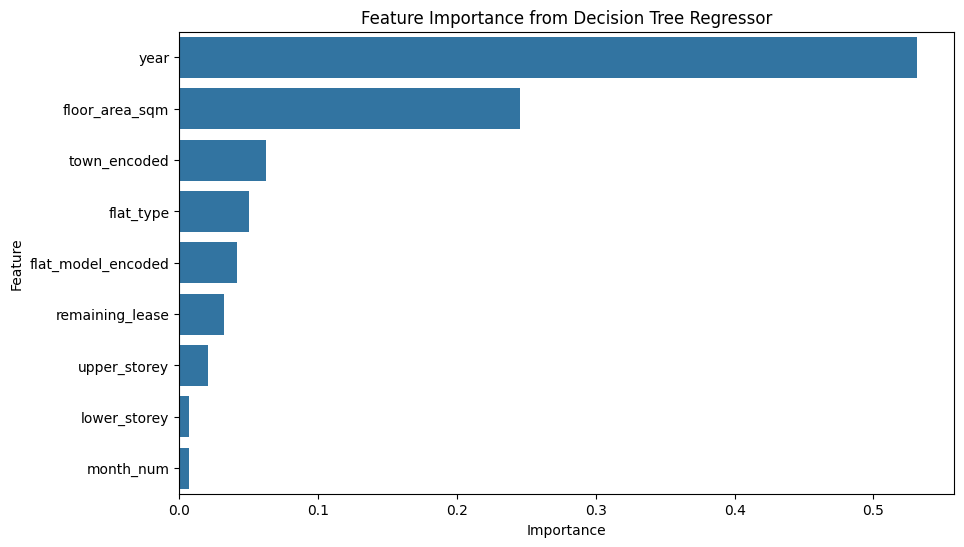

In [9]:
# Feature importance
feature_importances = pd.DataFrame({
    'Feature': x_train.columns,
    'Importance': dt_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importance from Decision Tree Regressor')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

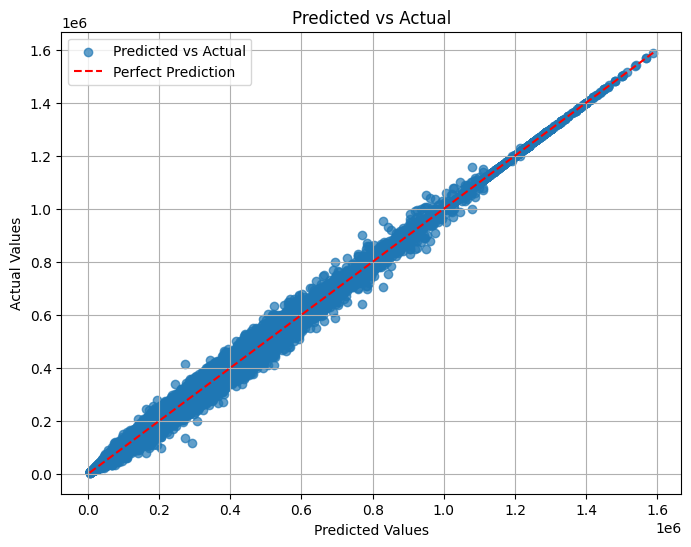

In [10]:
plt.figure(figsize=(8, 6))
plt.scatter(y_train_pred, y_train, alpha=0.7, label='Predicted vs Actual')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', linestyle='--', label='Perfect Prediction')
plt.title('Predicted vs Actual')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.grid(True)
plt.legend()
plt.show()

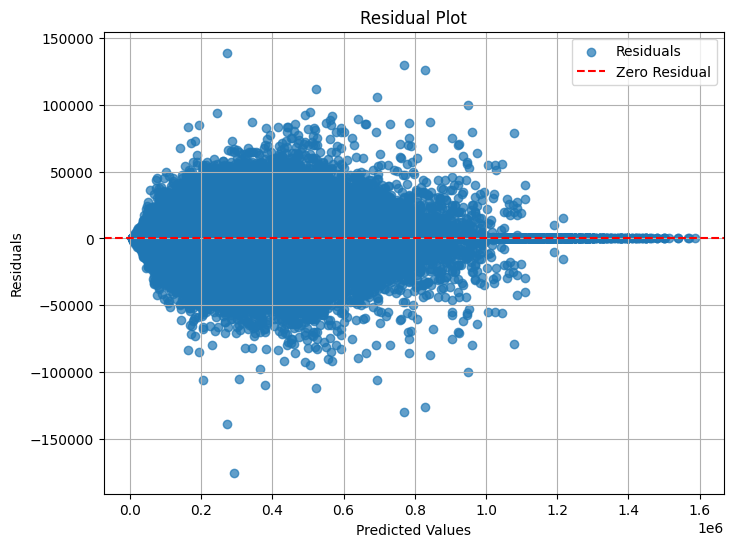

In [11]:
y_train = y_train.squeeze()  # Converts single-column DataFrame to Series
train_residuals = y_train - y_train_pred

# Plot residuals
plt.figure(figsize=(8, 6))
plt.scatter(y_train_pred, train_residuals, alpha=0.7, label='Residuals')
plt.axhline(0, color='red', linestyle='--', label='Zero Residual')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid(True)
plt.legend()
plt.show()

### 2.Random Forest

Now that we've implemented and evaluated a **Decision Tree**, we will now implement **Random Forest**. It is an ensemble method that combines multiple decision trees to reduce overfitting and improve generalization. By averaging the predictions of many trees, Random Forest mitigates the risk of a single tree's overfitting to the training data, leading to more accurate and stable predictions. We will implement a Random Forest model and compare its performance to that of the Decision Tree.

Random Forest is suitable for this prediction task and dataset due to its robustness to outliers and noise in dataset, ability to provide feature importance score, which provide interpretability of the model, and the capability to handle non-linear relationship between the features.

In [12]:
# Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

#### Modelling

In [13]:
# Fitting the RandomForest model
rf_model.fit(x_train, y_train.values.ravel())

RandomForestRegressor(random_state=42)

In [14]:
# Predict on both training and test sets
y_train_pred = rf_model.predict(x_train)
y_test_pred = rf_model.predict(x_test)

# Calculate metrics for the training set
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train, y_train_pred)

# Calculate metrics for the test set
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_test_pred)

# Print the evaluation metrics
print(f"Training Set Evaluation:")
print(f"  Root Mean Squared Error (Train): {rmse_train}")
print(f"  Mean Squared Error (Train): {mse_train}")
print(f"  R^2 Score (Train): {r2_train}")

print(f"\nTest Set Evaluation:")
print(f"  Root Mean Squared Error (Test): {rmse_test}")
print(f"  Mean Squared Error (Test): {mse_test}")
print(f"  R^2 Score (Test): {r2_test}")


Training Set Evaluation:
  Root Mean Squared Error (Train): 11190.725411486885
  Mean Squared Error (Train): 125232335.23529829
  R^2 Score (Train): 0.995809717190497

Test Set Evaluation:
  Root Mean Squared Error (Test): 26548.68789523073
  Mean Squared Error (Test): 704832828.9583708
  R^2 Score (Test): 0.9765150796748323


#### Random Forest Model Evaluation

Training Set Evaluation:  
The training RMSE is 11,191, indicating that the model fits the training data well, but not as closely as the decision tree. The R² score of 0.996 suggests the model explains a large proportion of the variance in the training data, though it's slightly less overfit compared to the decision tree.

Test Set Evaluation:  
The test RMSE is 26,549, which is still higher than the training RMSE, but significantly lower than that of the decision tree model. The test R² score of 0.977 indicates that the model performs well on unseen data, with a reasonably small gap between training and test performance, suggesting that the model generalizes better than the decision tree.

Conclusion:  
The Random Forest model shows improved generalization compared to the decision tree, with a smaller difference between training and test RMSE. While the training RMSE is still higher than the decision tree's, the test RMSE is much closer to the training RMSE, indicating less overfitting. The Random Forest model’s ability to combine predictions from multiple trees helps reduce the overfitting seen with the decision tree, making it a more robust model for this dataset.

#### Visualistion

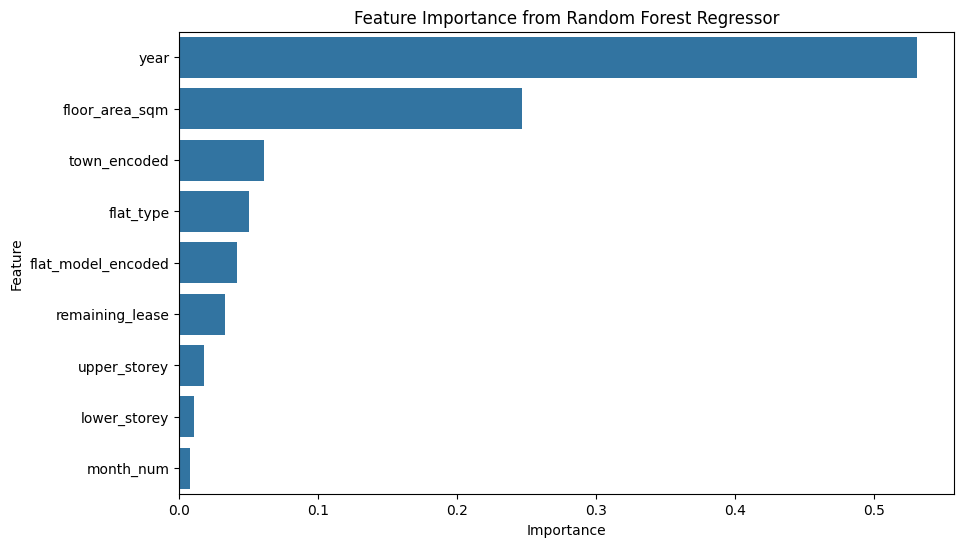

In [15]:
# Feature importance
feature_importances = pd.DataFrame({
    'Feature': x_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importance from Random Forest Regressor')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

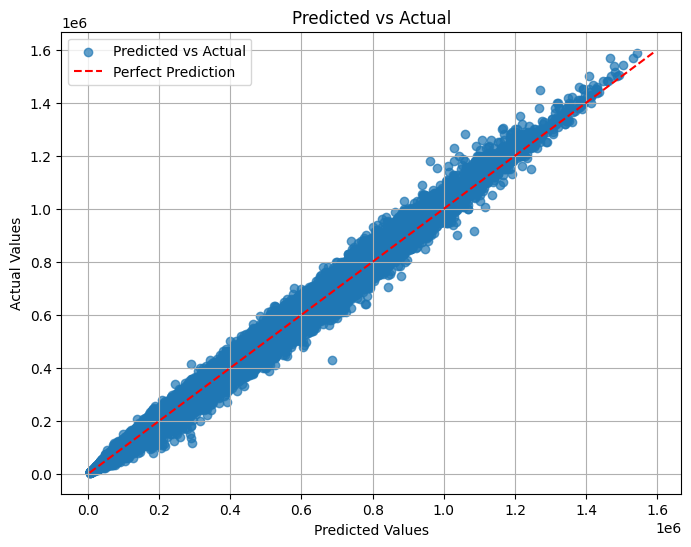

In [16]:
plt.figure(figsize=(8, 6))
plt.scatter(y_train_pred, y_train, alpha=0.7, label='Predicted vs Actual')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', linestyle='--', label='Perfect Prediction')
plt.title('Predicted vs Actual')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.grid(True)
plt.legend()
plt.show()

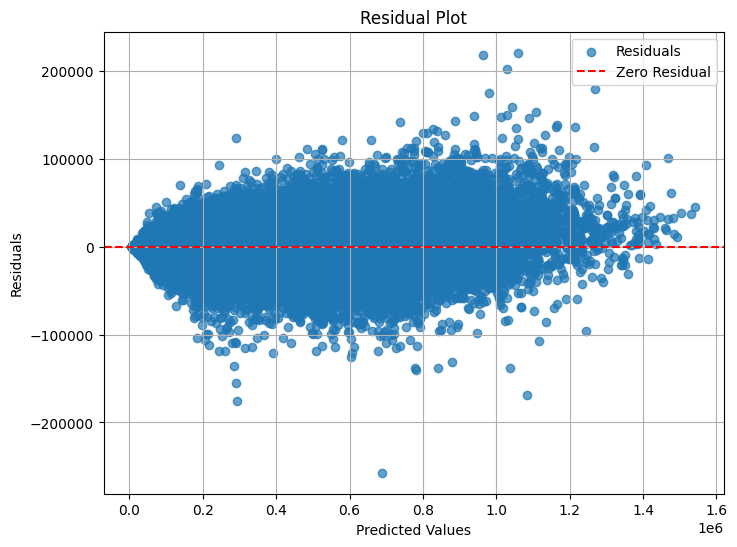

In [17]:
y_train = y_train.squeeze()  # Converts single-column DataFrame to Series
train_residuals = y_train - y_train_pred

# Plot residuals
plt.figure(figsize=(8, 6))
plt.scatter(y_train_pred, train_residuals, alpha=0.7, label='Residuals')
plt.axhline(0, color='red', linestyle='--', label='Zero Residual')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid(True)
plt.legend()
plt.show()

### Hyperparameter Tuning

##### Decision Tree Hyperparameter Tuning

In [18]:
# Define the Decision Tree Regressor
dt_model1 = DecisionTreeRegressor(random_state=42)

# Define the parameter grid
param_grid = {
    'max_depth': [5, 10, 15, None],          # Control tree depth
    'min_samples_split': [2, 5, 10],         # Minimum samples to split a node
    'min_samples_leaf': [1, 2, 4],           # Minimum samples in a leaf node
    'max_features': [None, 'sqrt', 'log2']   # Features considered for best split
}


# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=dt_model1,
    param_grid=param_grid,
    cv=3,                                  # 3-fold cross-validation
    scoring='neg_root_mean_squared_error', # Optimize for RMSE
    verbose=1,
    n_jobs=-1                              # Use all CPU cores
)

# Fit the model
grid_search.fit(x_train, y_train)

# Get the best parameters and model
best_params_dt = grid_search.best_params_
best_model_dt = grid_search.best_estimator_

# Predictions
y_train_pred = best_model_dt.predict(x_train)
y_test_pred = best_model_dt.predict(x_test)

# Evaluate on training data
rmse_train = root_mean_squared_error(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

# Evaluate on test data
rmse_test = root_mean_squared_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

# Print results
print(f"Best Parameters: {best_params_dt}")

print(f"\nTraining Set Evaluation:")
print(f"  Root Mean Squared Error (Train): {rmse_train}")
print(f"  Mean Squared Error (Train): {mse_train}")
print(f"  R^2 Score (Train): {r2_train}")

print(f"\nTest Set Evaluation:")
print(f"  Root Mean Squared Error (Test): {rmse_test}")
print(f"  Mean Squared Error (Test): {mse_test}")
print(f"  R^2 Score (Test): {r2_test}")

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Parameters: {'max_depth': None, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 10}

Training Set Evaluation:
  Root Mean Squared Error (Train): 20492.1100270035
  Mean Squared Error (Train): 419926573.3588174
  R^2 Score (Train): 0.9859492271042235

Test Set Evaluation:
  Root Mean Squared Error (Test): 31486.00189691453
  Mean Squared Error (Test): 991368315.4525054
  R^2 Score (Test): 0.9669677617943745


Tuning the decision tree reduced overfitting by increasing the training RMSE from 6208 to 20,492, which is typical when simplifying the model. While the test RMSE slightly improved from 35,081 to 31,486, the R² score on the test set also increased from 0.959 to 0.967, indicating better generalisation and overall performance after tuning.

In [19]:
# Initialize the decision tree model with the best parameters and random_state
dt_model_tuned = DecisionTreeRegressor(**best_params_dt, random_state=42)

# Perform cross-validation with the tuned model
scores = cross_val_score(dt_model_tuned, x_train, y_train.values.ravel(), cv=5, scoring='neg_mean_squared_error')

# Calculate RMSE for each fold
rmse_scores = np.sqrt(-scores)

# Print RMSE values as a list
print(f"RMSE for each fold: {list(rmse_scores)}")

# Calculate and print the mean RMSE
mean_rmse = rmse_scores.mean()
print(f"Mean RMSE (across all folds): {mean_rmse}")

RMSE for each fold: [33001.44071003202, 33107.47255216683, 33540.68338739034, 32411.19916240874, 33673.57969702239]
Mean RMSE (across all folds): 33146.875101804064


##### Random Forest Hyperparameter Tuning

RandomizedSearchCV is used to efficiently tune hyperparameters without taking too much time, especially since each Random Forest iteration already takes about 9 minutes due to the dataset size and model complexity. The default settings for Random Forest are already very strong, achieving an R² of 0.9958 on the training set and 0.9765 on the test set. Tuning is still done to try and improve the model further and make sure it performs well on unseen data.

In [20]:
# Define the parameter grid
param_dist = {
    'n_estimators': [100, 150, 200],          # Reduced tree counts for faster runtime
    'max_depth': [10, 20, None],            # Focus on shallow or fully-grown trees
    'min_samples_split': [2, 5, 10],           # Simpler splits to reduce complexity
    'max_features': [None, 'sqrt', 'log2']        # Randomly chosen features per split
}
# param_dist = {
#     'n_estimators': [100, 200, 300],          # Number of trees
#     'max_depth': [10, 20, None],              # Limit depth for generalization
#     'min_samples_split': [2, 5, 10],          # Minimum samples to split a node
#     'min_samples_leaf': [1, 2, 4],            # Minimum samples in a leaf
#     'max_features': ['sqrt', 'log2', None],   # Features considered for best split
#     'bootstrap': [True, False]                # Bootstrap sampling
# }

# Random Forest model
rf_model1 = RandomForestRegressor(random_state=42, n_jobs=-1)

# Use RandomizedSearchCV with fewer iterations and reduced grid size
random_search = RandomizedSearchCV(
    estimator=rf_model1,
    param_distributions=param_dist,
    n_iter=20,
    cv=2,
    scoring='neg_root_mean_squared_error',  # Optimize for RMSE
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit the RandomizedSearchCV
random_search.fit(x_train, y_train.values.ravel())

# Get the best parameters and model
best_params_rf = random_search.best_params_
best_model_rf = random_search.best_estimator_

# Predictions
y_train_pred = best_model_rf.predict(x_train)
y_test_pred = best_model_rf.predict(x_test)

# Evaluate on training data
rmse_train = root_mean_squared_error(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

# Evaluate on test data
rmse_test = root_mean_squared_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

# Print results
print(f"Best Parameters: {best_params_rf}")

print(f"\nTraining Set Evaluation:")
print(f"  Root Mean Squared Error (Train): {rmse_train}")
print(f"  Mean Squared Error (Train): {mse_train}")
print(f"  R^2 Score (Train): {r2_train}")

print(f"\nTest Set Evaluation:")
print(f"  Root Mean Squared Error (Test): {rmse_test}")
print(f"  Mean Squared Error (Test): {mse_test}")
print(f"  R^2 Score (Test): {r2_test}")


Fitting 2 folds for each of 20 candidates, totalling 40 fits
Best Parameters: {'n_estimators': 150, 'min_samples_split': 2, 'max_features': None, 'max_depth': None}

Training Set Evaluation:
  Root Mean Squared Error (Train): 11120.315244868778
  Mean Squared Error (Train): 123661411.14526096
  R^2 Score (Train): 0.9958622804218474

Test Set Evaluation:
  Root Mean Squared Error (Test): 26511.722816720136
  Mean Squared Error (Test): 702871446.710599
  R^2 Score (Test): 0.9765804326265162


Hyperparameter tuning on the Random Forest model resulted in only minimal improvement, with test RMSE and R² values remaining almost unchanged before and after tuning. Given the negligible gains, the time spent on tuning does not justify the effort. This suggests that the default RandomForestRegressor settings is already well-optimized for the dataset.